In [39]:
import os
import time
import numpy as np
import random
import torch
from tqdm import tqdm
import sys
sys.path.append('../')
import utils.parsing

In [40]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [41]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


## Data setup

In [42]:
dataset_root = os.path.join(os.getcwd(), '..', 'data', 'idao_dataset')
train_source = os.path.join(dataset_root, 'train')
print(dataset_root)

/home/sovereign/projects/idao2021robosapiens/track_1/../data/idao_dataset


In [43]:
classes = [
    'ER_1', 'ER_3', 'ER_6', 'ER_10', 'ER_20', 'ER_30',
    'NR_1', 'NR_3', 'NR_6', 'NR_10', 'NR_20', 'NR_30'
]

In [44]:
train_dir = os.path.join(os.getcwd(), '..', 'tmp', 'train')
val_dir = os.path.join(os.getcwd(), '..', 'tmp', 'val')

In [45]:
import torchvision
from torchvision import transforms, models
import matplotlib.pyplot as plt
import pandas as pd

In [46]:
# Augmentations and denoising can be added here
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
#     transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

In [47]:
batch_size = 1
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

In [48]:
len(train_dataloader), len(train_dataset)

(11169, 11169)

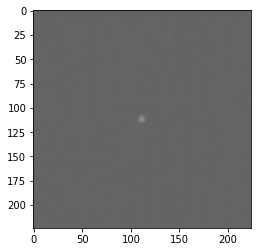

In [49]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

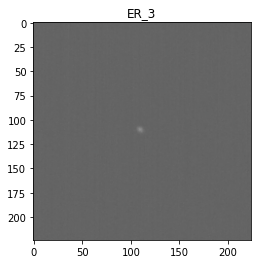

In [50]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=classes[y_item])

## Model setup

In [51]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            # len of dataloader is a number of batches in an epoch
            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model

In [52]:
model = models.resnet18(pretrained=True)

# Disable grad for all conv layers
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, len(classes))

model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [53]:
train_model(model, loss, optimizer, scheduler, num_epochs=10)

Epoch 0/9:
train Loss: 2.0530 Acc: 0.1772
val Loss: 1.8528 Acc: 0.2295
Epoch 1/9:
train Loss: 2.0011 Acc: 0.1875
val Loss: 1.7124 Acc: 0.3356
Epoch 2/9:
train Loss: 1.9569 Acc: 0.2096
val Loss: 1.6339 Acc: 0.3633
Epoch 3/9:
train Loss: 1.9043 Acc: 0.2236
val Loss: 1.5115 Acc: 0.3973
Epoch 4/9:
train Loss: 1.8761 Acc: 0.2436
val Loss: 1.7965 Acc: 0.4022
Epoch 5/9:
train Loss: 1.8262 Acc: 0.2605
val Loss: 1.8302 Acc: 0.4000
Epoch 6/9:
train Loss: 1.5790 Acc: 0.4216
val Loss: 1.9300 Acc: 0.3660
Epoch 7/9:
train Loss: 1.5722 Acc: 0.4250
val Loss: 1.7721 Acc: 0.3906
Epoch 8/9:
train Loss: 1.5696 Acc: 0.4196
val Loss: 1.8227 Acc: 0.3557
Epoch 9/9:
train Loss: 1.5653 Acc: 0.4213
val Loss: 2.1030 Acc: 0.3485


/home/sovereign/.local/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
100%|██████████| 2235/2235 [00:17<00:00, 130.04it/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [54]:
# TODO: setup loss-function

In [55]:
# TODO: Quality metric: (AUC - MAE) * 1000

## Mark up test data

In [58]:
test_dir = os.path.join(dataset_root, '..', '..', 'tmp', 'test')

In [60]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

test_dataset = ImageFolderWithPaths(test_dir, val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [61]:
model.eval()

test_img_paths = []
test_class_pred = []
# test_regress_pred = []

# labels are always 'unknown' and unused
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_class_pred.append(
        torch.nn.functional.softmax(preds, dim=1).data.cpu().numpy()) # fix [:,1]
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_class_pred)

100%|██████████| 16564/16564 [06:44<00:00, 41.00it/s]


## Building a solution

***id*** - filename without extension<br/>
***classification_predictions*** - '?'<br/>
***regression_predictions*** - '?'

In [ ]:
len(test_img_paths)

In [ ]:
len(test_class_pred)

In [ ]:
len(test_dataloader)

In [ ]:
submission_df = pd.DataFrame.from_dict(
    {'id': test_img_paths,
     'classification_predictions': test_class_pred,
#      'regression_predictions': test_regress_pred
    }
)

In [ ]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('/kaggle/working/test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=6)

In [ ]:
submission_df.to_csv('submission.csv')